In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from variational_forms import _VariationalForm
from feature_maps import MediumFeatureMap
from pegasos_experiment import generate_qsvm_data, run_advanced_experiment
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from quantum_neural_networks import QuantumNeuralNetwork
from qiskit import BasicAer

In [30]:
blue = '#1f77b4'
orange = '#ff7f0e'
green = '#2ca02c'
red = '#d62728'
violet = '#9467bd'
grey = '#7f7f7f'
cyan = '#17becf'

colormap = {
    1.0 : blue,
    2.0 : blue,
    4.0 : green,
    8.0 : red,
    64. : violet,
    256. : grey,
    512. : cyan,
    1024. : orange,

}

# other constants
lower_percentile = 0.159
upper_percentile = 0.841

plt.rcParams.update({'font.size': 24,
                     'xtick.labelsize': 20,
                     'ytick.labelsize': 20,
                     'axes.titlesize': 28,
                     'axes.labelsize': 28,
                     'mathtext.fontset': 'stix',
                     'font.family': 'STIXGeneral'})

In [47]:
margin = +0.1
positive = 'positive' if margin > 0 else 'negative'
filename = f'data/advanced_margin_{margin}_data.csv'
# data size
M = 100
# iterations
N = 1000
# number of repeats per experiment
n = 10


In [48]:
shots = [1,4,8,64,256,512,1024]
Cs = [10.,1000.]

for C in Cs:
    run_advanced_experiment(margin,C,N,shots,M,0,n)
        

KeyboardInterrupt: 

In [49]:
 # Feature map for the experiment
feature_map = MediumFeatureMap(2,4)


# Creating artificial data
(X,y), (Xt,yt) = generate_qsvm_data(feature_map,margin,M,100)

np.random.seed(41)

# Change to qasm-simulator if noise is modelled via shots
adhoc_backend = QuantumInstance(BasicAer.get_backend('statevector_simulator'))

adhoc_kernel = QuantumKernel(feature_map=feature_map.get_reduced_params_circuit(), quantum_instance=adhoc_backend)

# Kernel evaluation
K = adhoc_kernel.evaluate(x_vec=X)


In [50]:
# load data
data = pd.read_csv(filename)

epsilons = []
stops = []


for j, r in data.iterrows():
    file = f"data/dumps/{int(r['seed'])}_R_{int(r['R'])}_C_{r['C']}_M_{int(r['M'])}_margin_{margin}"
    history = pickle.load(open(file,'rb'))
    a = history['a_noisy']
    a_state = history['a_exact']
    y_pred = history['y_pred']
    evals = history['evaluations']
    hinges = history['hinge_loss'] 
    y_state = history['y']

    #eps = np.array([np.max(np.abs(np.sum(y*(a[i] - a_state[-1])*K,axis=1))) for i in range(len(a_state))])
    eps = np.array([np.max(yp - y))

    diff = np.abs(hinges[1:] - hinges[:-1])
    stop = np.where(diff < 1e-4)[0][0]
    epsilons.append(eps)
    stops.append(stop)

In [51]:
stops = np.array(stops)
epsilons = np.array(epsilons)

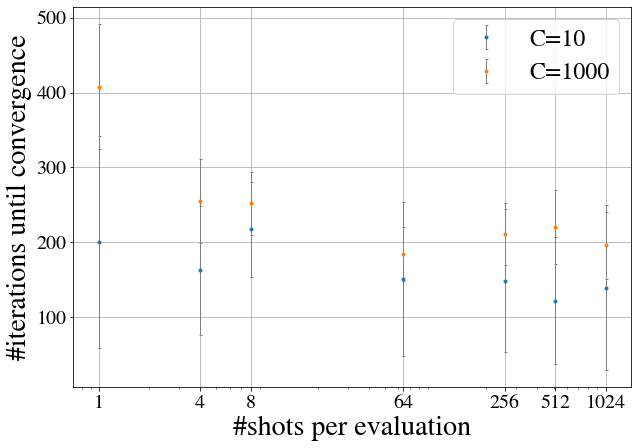

In [52]:
def plot_conv(C):
    stops_R = np.array([stops[(data['R'] == R) & (data['C'] == C)] for R in shots])
    stop_means = np.mean(stops_R,axis=1)
    stop_std = np.std(stops_R,axis=1)
    plt.errorbar(shots,stop_means,yerr=stop_std,label=f'C={int(C)}',marker='.',ecolor='grey',elinewidth=1.,ls='',capsize=1 + M/200)

plt.figure(figsize=(10,7))
for C in Cs:
    plot_conv(C)
plt.xscale('log')
plt.xticks(shots,shots)
plt.xlabel('#shots per evaluation')
plt.ylabel('#iterations until convergence')
plt.legend()
plt.grid()
plt.savefig(f'plots/convergence_{positive}_margin.png',dpi=200)


[-4.76182991 -2.90138954]
[-4.80341744 15.52738315]


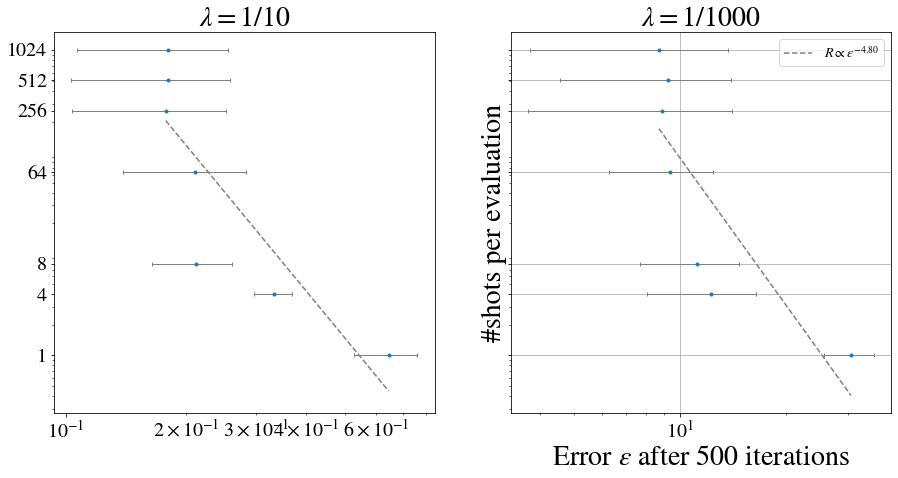

In [62]:
def plot_epsilon(C,stop_at,ax):
    filter = data['C'] == C
    epsC = np.array([epsilons[:,stop_at][filter & (data['R'] == R)] for R in shots])
    eps_means = np.mean(epsC,axis=1)
    eps_std = np.std(epsC,axis=1)
    ax.errorbar(eps_means,shots,xerr=eps_std,marker='.',ecolor='grey',elinewidth=1.,ls='',capsize=2)
    p = np.polyfit(np.log(eps_means),np.log(shots),1)
    print(p)
    efine = np.linspace(np.min(eps_means),np.max(eps_means))
    ax.plot(efine,np.exp(p[1])*efine**p[0],'--',color='grey',label=r'$R\propto\varepsilon^{{%.2f}}$'%p[0])
    ax.set_title(r'$\lambda = 1/{{%s}}$'%int(C))
    ax.set_xscale('log')
    ax.set_yscale('log')

shots = [1,4,8,64,256,512,1024]
fig, axs = plt.subplots(1,2,sharey=True,figsize=(15,7))
for i, C in enumerate(Cs):
    plot_epsilon(C,500,axs[i])

plt.yticks(shots,shots)
plt.ylabel('#shots per evaluation')
plt.xlabel(r'Error $\varepsilon$ after 500 iterations')
plt.legend(fontsize=14)
plt.grid()

#plt.savefig(f'plots/exponent_{positive}_margin_500.png',dpi=200)


[-2.07023258 -0.94907394]
[-3.4009787  10.83427561]


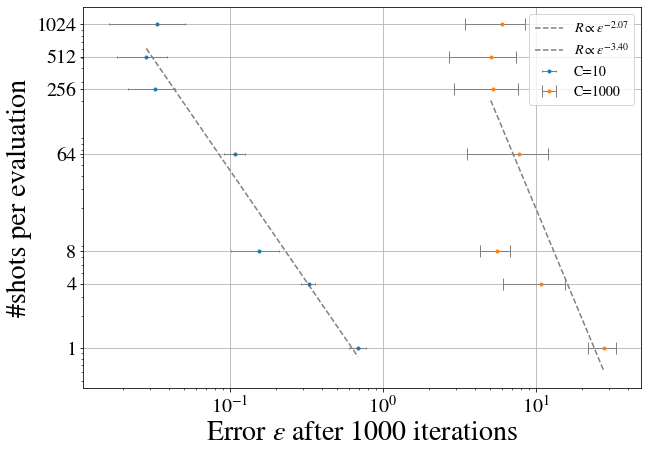

In [54]:
shots = [1,4,8,64,256,512,1024]
plt.figure(figsize=(10,7))
for C in Cs:
    plot_epsilon(C,-1)
plt.xscale('log')
plt.yscale('log')
plt.yticks(shots,shots)
plt.ylabel('#shots per evaluation')
plt.xlabel(r'Error $\varepsilon$ after 1000 iterations')
plt.legend(fontsize=14)
plt.grid()
plt.savefig(f'plots/exponent_{positive}_margin_1000.png',dpi=200)

[1.2202436  4.28757289]
[-4.49793057 17.55538704]


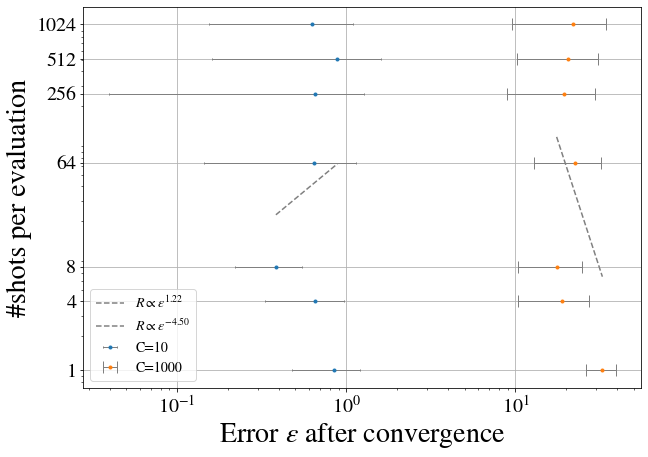

In [55]:
def plot_epsilon_convergence(C):
    filter = data['C'] == C
    epsilons_conv = np.array([epsilons[i,stops[i]] for i in range(len(epsilons))])
    epsC = np.array([epsilons_conv[filter & (data['R'] == R)] for R in shots])
    eps_means = np.mean(epsC,axis=1)
    eps_std = np.std(epsC,axis=1)
    plt.errorbar(eps_means,shots,xerr=eps_std,label=f'C={int(C)}',marker='.',ecolor='grey',elinewidth=1.,ls='',capsize=1 + C/200)
    p = np.polyfit(np.log(eps_means),np.log(shots),1)
    print(p)
    if M == 100:
        efine = np.linspace(np.min(eps_means),np.max(eps_means))
        plt.plot(efine,np.exp(p[1])*efine**p[0],'--',color='grey',label=r'$R\propto\varepsilon^{{%.2f}}$'%p[0])


plt.figure(figsize=(10,7))
for C in Cs:
    plot_epsilon_convergence(C)
plt.xscale('log')
plt.yscale('log')
plt.yticks(shots,shots)
plt.ylabel('#shots per evaluation')
plt.xlabel(r'Error $\varepsilon$ after convergence')
plt.legend(fontsize=14)
plt.grid()
plt.savefig(f'plots/exponent_{positive}_margin_convergence.png',dpi=200)


In [56]:
stops

array([126, 193, 284,  76, 222, 191,   6,  49, 238, 237,  90,  72,  33,
        72, 346,  60, 269, 202, 100,  52, 186, 185, 222, 177,  73,  84,
        26,  42, 159, 338, 329,  86,  93, 161, 189, 228,  93, 205,  29,
        25,  25, 318,  49, 149, 230, 217, 139,  82,  97,  31,  95, 164,
       356, 203, 161,  10, 459,  52, 180,  92, 376, 220, 149, 370, 188,
        97, 288, 172, 271, 324, 416, 229, 299, 195, 198, 219, 196, 496,
       231, 289, 152, 252, 290, 260, 345, 277, 199, 252, 219, 219, 219,
       540, 242, 223, 218, 229, 229, 207, 523, 319, 322, 155, 191, 150,
       150, 396, 234, 234, 173, 284, 284, 272, 366, 200, 291, 218, 218,
       243, 184, 275, 362, 241, 167, 174, 237, 166, 399, 298, 213, 191,
       221, 215, 193, 320, 163, 208, 123, 123, 123, 116])

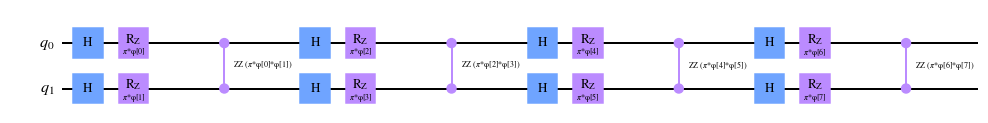

In [ ]:
from qiskit.circuit.library import ZZFeatureMap
f = MediumFeatureMap(2,4)
f.circuit.draw(output='mpl',filename='plots/feature_map.eps')


In [ ]:

(X,y),_ = generate_qsvm_data(f,0.1,100,0)
(X2,y2),_ = generate_qsvm_data(f,-0.1,100,0)

In [ ]:
varform = _VariationalForm(2,1,None)
qnn = QuantumNeuralNetwork(feature_map=f,variational_form=varform)
np.random.seed(41)
theta = np.random.uniform(0, 2*np.pi, size=qnn.d)
qnn.fit_theta(theta)



In [ ]:
x = np.linspace(0,1,100)
xx,yy = np.meshgrid(x,x)
xxx = np.array(list(zip(xx.reshape(-1),yy.reshape(-1)))).reshape(-1,2)
Z = qnn.predict_proba(xxx)


In [ ]:
print(qnn.feature_map.get_reduced_params_circuit().draw(output='latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \gate{\mathrm{H}} & \gate{\mathrm{R_Z}\,(\mathrm{\pi*{\ensuremath{\phi}}[0]})} & \ctrl{1} & \dstick{\hspace{2.0em}\mathrm{ZZ}\,(\mathrm{\pi*{\ensuremath{\phi}}[0]*{\ensuremath{\phi}}[1]})} \qw & \qw & \qw & \gate{\mathrm{H}} & \gate{\mathrm{R_Z}\,(\mathrm{\pi*{\ensuremath{\phi}}[0]})} & \ctrl{1} & \dstick{\hspace{2.0em}\mathrm{ZZ}\,(\mathrm{\pi*{\ensuremath{\phi}}[0]*{\ensuremath{\phi}}[1]})} \qw & \qw & \qw & \gate{\mathrm{H}} & \gate{\mathrm{R_Z}\,(\mathrm{\pi*{\ensuremath{\phi}}[0]})} & \ctrl{1} & \dstick{\hspace{2.0em}\mathrm{ZZ}\,(\mathrm{\pi*{\ensuremath{\phi}}[0]*{\ensuremath{\phi}}[1]})} \qw & \qw & \qw & \gate{\mathrm{H}} & \gate{\mathrm{R_Z}\,(\mathrm{\pi*{\ensuremath{\phi}}[0]})} & \ctrl{1} & \dstick{\hspace{2.0em}\mathrm{ZZ}\,(\mathrm{\pi*{\ensuremath{\phi}}[0]*

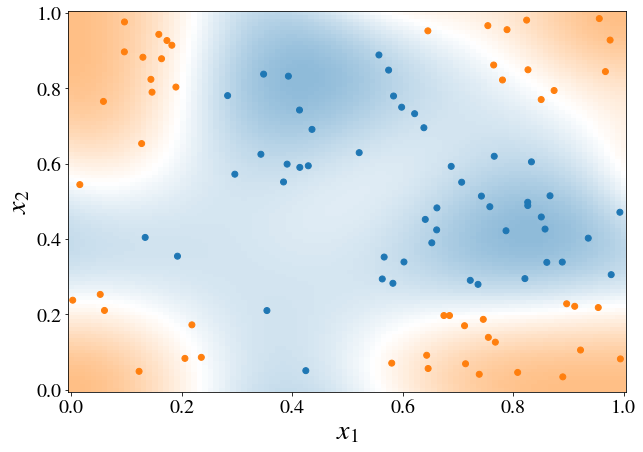

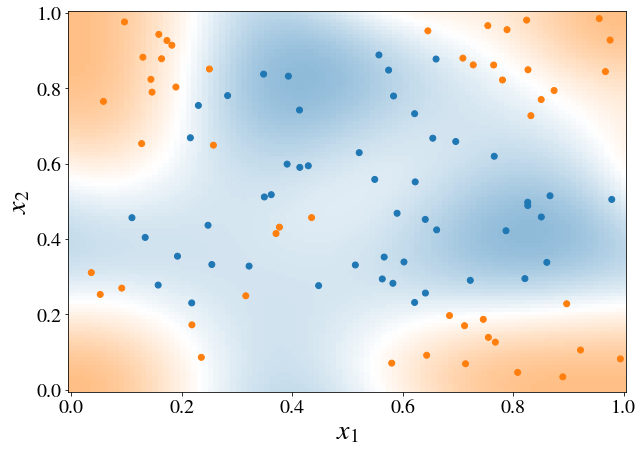

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

colormap = {1 : blue, -1 : orange}

# blue
color_0 = '#1f77b4'
color_0_light = '#8fbbd9'

# orange
color_1 = '#ff7f0e'
color_1_light = '#ffbf86'

cmap = LinearSegmentedColormap.from_list('blue_orange', [color_1_light, '#FFFFFF', color_0_light], N=100)

plt.figure(figsize=(10,7))
plt.scatter(X[:,0],X[:,1],c= list(map(colormap.get,y)),zorder=100)
plt.pcolormesh(xx, yy, Z.reshape(xx.shape), cmap=cmap, alpha=1)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('plots/data_separable.png',dpi=300,bbox_inches='tight')
plt.figure(figsize=(10,7))
plt.scatter(X2[:,0],X2[:,1],c=list(map(colormap.get,y2)),zorder=100)
plt.pcolormesh(xx, yy, Z.reshape(xx.shape), cmap=cmap, alpha=1)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('plots/data_overlap.png',dpi=300,bbox_inches='tight')
